In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_recall_curve, f1_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Завантаження даних, первинний аналіз

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Train.csv')
TEST = pd.read_csv('/content/drive/MyDrive/Test.csv')
print(df.shape)
df.head(10)

(2154048, 19)


,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0
5,0000296564272665ccd2925d377e124f3306b01e,LOUGA,K > 24 month,8500.0,17.0,9000.0,3000.0,18.0,NaN,252.0,70.0,91.0,NaN,NaN,NO,62,MIXT:500F= 2500F on net _2500F off net;2d,18.0,0
6,00002b0ed56e2c199ec8c3021327229afa70f063,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN,0
7,0000313946b6849745963442c6e572d47cd24ced,DAKAR,K > 24 month,7000.0,16.0,7229.0,2410.0,22.0,1601.0,77.0,29.0,100.0,NaN,NaN,NO,55,All-net 500F=2000F;5d,8.0,0
8,0000398021ccd3a488fa1a63dee3b2f0d471f9fd,DAKAR,K > 24 month,1500.0,3.0,1502.0,501.0,12.0,NaN,2.0,53.0,2.0,NaN,NaN,NO,31,NaN,NaN,0
9,00003d165737109921ebd21f883cb8cff028b626,TAMBACOUNDA,K > 24 month,4000.0,8.0,4000.0,1333.0,8.0,NaN,1620.0,9.0,NaN,NaN,NaN,NO,45,On-net 500F_FNF;3d,8.0,0


In [ ]:
df.columns

Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')

In [ ]:
categorical_features = ['REGION', 'TOP_PACK', 'TENURE', 'MRG']
numerical_features = set(df.columns) - set(categorical_features) - set(['user_id', 'CHURN'])
numerical_features = list(numerical_features)
numerical_features

['REGULARITY',
 'REVENUE',
 'ON_NET',
 'DATA_VOLUME',
 'ZONE1',
 'FREQ_TOP_PACK',
 'FREQUENCE',
 'ARPU_SEGMENT',
 'TIGO',
 'FREQUENCE_RECH',
 'ZONE2',
 'MONTANT',
 'ORANGE']

In [ ]:
df.isna().sum() / df.shape[0] * 100

user_id            0.000000
REGION            39.428044
TENURE             0.000000
MONTANT           35.131018
FREQUENCE_RECH    35.131018
REVENUE           33.706213
ARPU_SEGMENT      33.706213
FREQUENCE         33.706213
DATA_VOLUME       49.229776
ON_NET            36.520774
ORANGE            41.561191
TIGO              59.887988
ZONE1             92.120835
ZONE2             93.648052
MRG                0.000000
REGULARITY         0.000000
TOP_PACK          41.902223
FREQ_TOP_PACK     41.902223
CHURN              0.000000
dtype: float64

Бачимо, що в наших даних багато нанів, з цим потрібно буде щось зробити.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


# Подивимось на розподіли наших змінних

0    81.245265
1    18.754735
Name: CHURN, dtype: float64

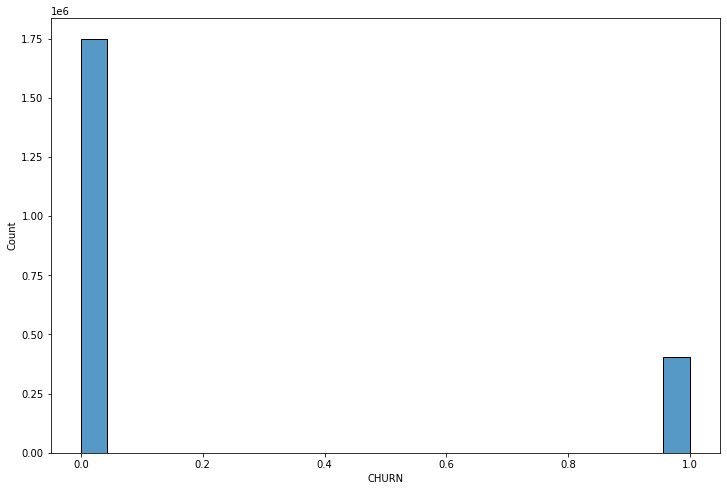

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df['CHURN'])
df['CHURN'].value_counts() / df['CHURN'].shape[0] * 100

Бачимо, що таргет незбалансований, це потрібно буде врахувати. Подивимось на розподіл категоріальних фіч.

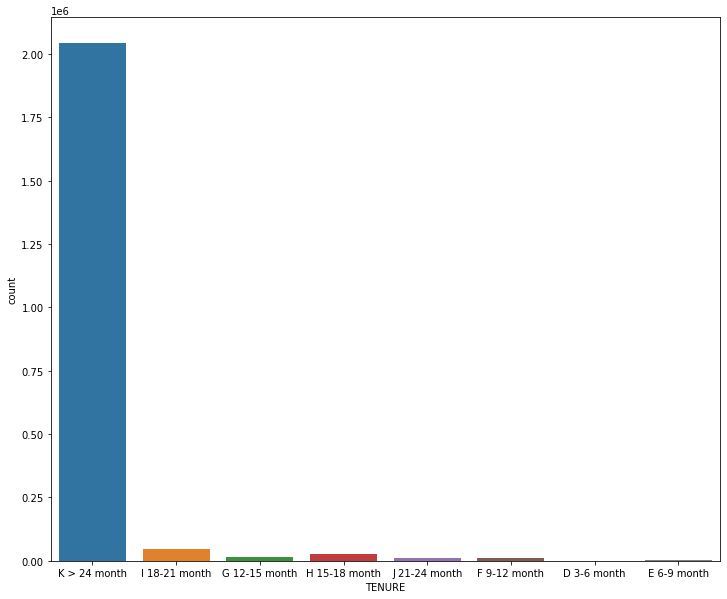

In [ ]:
plt.figure(figsize=(12, 10))
sns.countplot(data=df[(df['TENURE'].isna() == False)], x='TENURE')

In [ ]:
tenure_map = {'K > 24 month' : 24, 'I 18-21 month':21, 'G 12-15 month':15,'H 15-18 month' : 18,'J 21-24 month' : 24, 'F 9-12 month':12, 'D 3-6 month':6, 'E 6-9 month':9 }

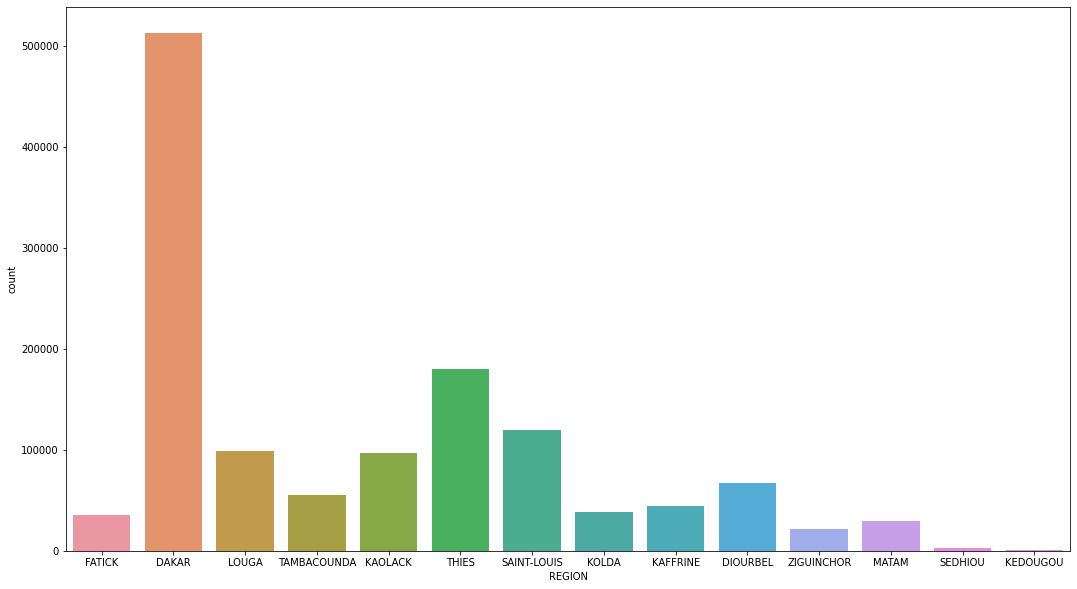

In [ ]:
plt.figure(figsize=(18, 10))
sns.countplot(data=df[(df['REGION'].isna() == False)], x='REGION')

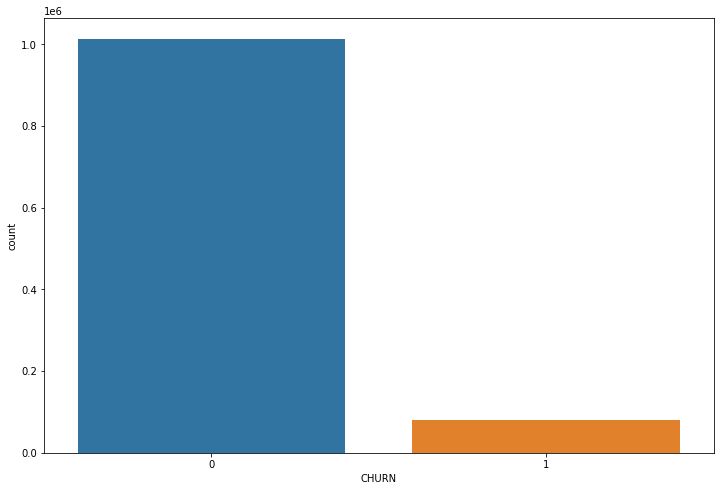

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=df[(df['DATA_VOLUME'].isna() == False)], x='CHURN')

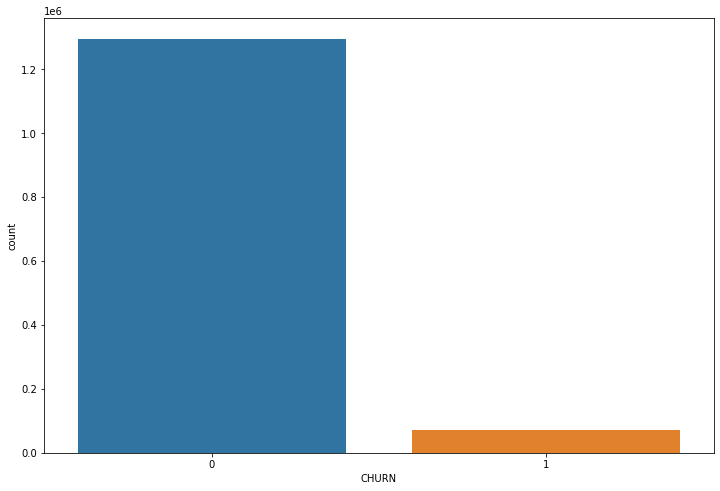

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=df[(df['ON_NET'].isna() == False)], x='CHURN')

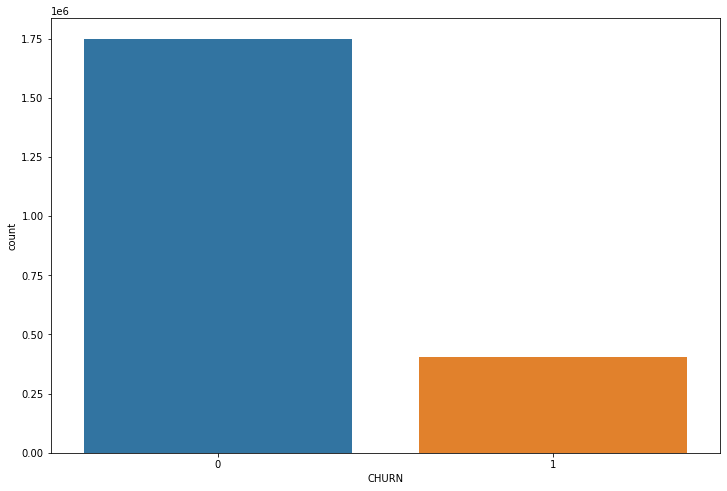

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=df[(df['REGULARITY'].isna() == False)], x='CHURN')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


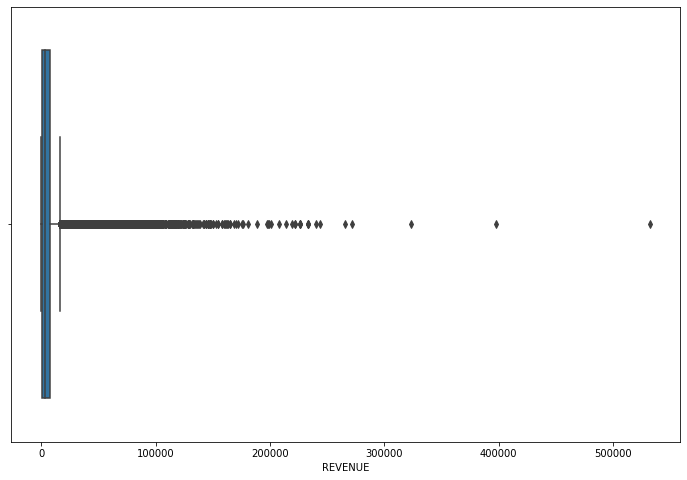

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(df['REVENUE'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


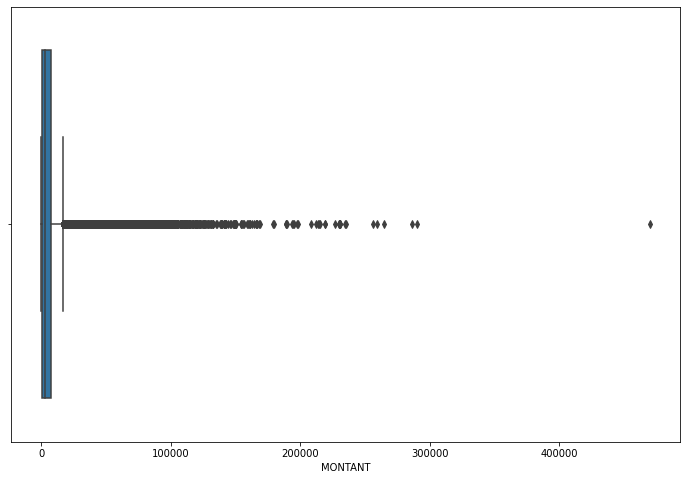

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(df['MONTANT'])

In [ ]:
df['TOP_PACK'].value_counts()

idx=df.TOP_PACK.value_counts()[df.TOP_PACK.value_counts()<20].index.to_list()
print(idx)
df.TOP_PACK = df.TOP_PACK.apply(lambda x : 'Not_popular' if x in idx else x)
idx=TEST.TOP_PACK.value_counts()[TEST.TOP_PACK.value_counts()<20].index.to_list()

TEST.TOP_PACK = TEST.TOP_PACK.apply(lambda x : 'Not_popular' if x in idx else x)


['1000=Unlimited7Day', 'Data_EVC_2Go24H', 'IVR Echat_Monthly_500F', 'NEW_CLIR_PERMANENT_LIBERTE_MOBILE', 'EVC_JOKKO30', 'CVM_500f=2GB', 'CVM_100F_unlimited', 'EVC_Jokko_Weekly', 'CVM_100f=200 MB', 'EVC_700Mo', 'CVM_On-net 400f=2200F', 'pack_chinguitel_24h', 'GPRS_3000Equal10GPORTAL', 'pilot_offer6', 'All-net 500= 4000off+4000on;24H', 'CVM_On-net 1300f=12500', 'EVC_MEGA10000F', 'pilot_offer7', 'EVC_4900=12000F', 'Data_Mifi_10Go_Monthly', 'APANews_weekly', '150=unlimited pilot auto', 'EVC_1Go', 'YMGX on-net 100=700F, 24H', 'NEW_CLIR_TEMPRESTRICTED_LIBERTE_MOBILE', 'SMS Max', 'pilot_offer5', 'FIFA_TS_weekly', '301765007', 'APANews_monthly', 'pilot_offer4', '1500=Unlimited7Day', 'FIFA_TS_monthly', 'GPRS_5Go_7D_PORTAL', 'Data:OneTime_Pilot_1.5GB', 'CVM_100f=500 onNet', 'Data:1000F=700MB,7d', 'ESN_POSTPAID_CLASSIC_RENT', 'Postpaid FORFAIT 10H Package', 'Package3_Monthly', 'CVM_150F_unlimited', 'GPRS_PKG_5GO_ILLIMITE', 'Data_Mifi_20Go', 'GPRS_BKG_1000F MIFI', 'Data_Mifi_10Go', 'MegaChrono_300

In [ ]:
def find_pattern(string: str, pattern: str, inception=0):
    # Returns pattern if it was finded else returns None
    if len(re.findall(pattern, string)) > inception:
        return re.findall(pattern, string)[inception][:-1]
    return np.NaN


def add_top_pack(df):
  idx = df[df['TOP_PACK'].isna() == False].index
  df['TOP_PACK'] = df['TOP_PACK'].str.lower()
  df.loc[idx, 'F1'] = df.loc[idx, 'TOP_PACK'].apply(lambda x: find_pattern(x, '[0-9]+f'))
  df.loc[idx, 'F2'] = df.loc[idx, 'TOP_PACK'].apply(lambda x: find_pattern(x, '[0-9]+f', 1))

  df.loc[idx, 'days'] = df.loc[idx, 'TOP_PACK'].apply(lambda x: find_pattern(x, '[0-9]+d'))

  df.loc[idx, 'daily'] = df.loc[idx, 'TOP_PACK'].apply(lambda x: find_pattern(x, 'daily'))
  df['nans_count'] = df.apply(lambda x: x.isna().sum(), axis=1)
  df.drop(columns=['MRG'], inplace=True)
  df.TENURE = df.TENURE.map(tenure_map)
  df['data_volume/regularity'] = df['DATA_VOLUME']/(df['REGULARITY']+1)
  df['REVENUE/FREQUENCE'] = df['REVENUE']/(df['FREQUENCE']+1)
  df[df['TOP_PACK'].isna()]['FREQ_TOP_PACK'].fillna(0, inplace=True)
  df[['F1','F2','days']].fillna(0,inplace=True)
  df[['daily','TOP_PACK']] = df[['daily','TOP_PACK']].fillna('unknown')
  return df

df = add_top_pack(df)
TEST = add_top_pack(TEST)



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/panda

In [ ]:
df

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,F1,F2,days,daily,nans_count,data_volume/regularity,REVENUE/FREQUENCE
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,24,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54,on net 200f=unlimited _call24h,8.0,0,200,NaN,NaN,unknown,3,0.072727,236.166667
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,unknown,NaN,1,NaN,NaN,NaN,unknown,18,NaN,NaN
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,24,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,17,on-net 1000f=10milf;10d,1.0,0,1000,NaN,10,unknown,6,NaN,340.000000
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,24,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,62,"data:1000f=5gb,7d",11.0,0,1000,NaN,7,unknown,4,695.301587,710.631579
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,24,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,11,mixt 250f=unlimited_call24h,2.0,0,250,NaN,NaN,unknown,7,NaN,492.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154043,ffffe85215ddc71a84f95af0afb0deeea90e6967,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,unknown,NaN,0,NaN,NaN,NaN,unknown,18,NaN,NaN
2154044,ffffeaaa9289cdba0ac000f0ab4b48f4aa74ed15,THIES,24,6100.0,15.0,5800.0,1933.0,15.0,621.0,26.0,40.0,40.0,NaN,NaN,55,"data: 200 f=100mb,24h",9.0,0,NaN,NaN,NaN,unknown,6,11.089286,362.500000
2154045,fffff172fda1b4bb38a95385951908bb92379809,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,unknown,NaN,1,NaN,NaN,NaN,unknown,18,NaN,NaN
2154046,fffff5911296937a37f09a37a549da2e0dad6dbb,THIES,24,10000.0,11.0,7120.0,2373.0,13.0,NaN,0.0,140.0,13.0,NaN,NaN,28,all-net 500f=2000f;5d,12.0,0,500,2000,5,unknown,4,NaN,508.571429


In [ ]:
region = df.groupby('REGION').mean()
reg_test = TEST.groupby('REGION').mean()
region.drop('CHURN', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_reg_mean_all'] = region[i]
        reg_test[i+'_reg_mean_all'] = region[i]
        reg_test.drop(i, 1, inplace = True)
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

df = pd.merge(df, region, on='REGION', how = 'left')
TEST = pd.merge(TEST, reg_test, on='REGION', how = 'left')



In [ ]:
df['REGION'].fillna('unknown', inplace=True)
TEST['REGION'].fillna('unknown', inplace=True)


In [ ]:
def fillna_bygroup(group_variables, variable):
    df[variable] = df.groupby(group_variables)[variable].transform(lambda x: x.fillna(x.mean()))
    TEST[variable] = df.groupby(group_variables)[variable].transform(lambda x: x.fillna(x.mean()))
    
for feature in numerical_features:
    fillna_bygroup('REGION', feature)

In [ ]:
encoder = LabelEncoder()

def encode(features):
  for feature in features:
    df[feature] = encoder.fit_transform(df[feature])
    TEST[feature] = encoder.transform(TEST[feature])


encode(['REGION','TOP_PACK','daily'])


In [ ]:
df

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,F1,F2,days,daily,nans_count,data_volume/regularity,REVENUE/FREQUENCE,TENURE_reg_mean_all,MONTANT_reg_mean_all,FREQUENCE_RECH_reg_mean_all,REVENUE_reg_mean_all,ARPU_SEGMENT_reg_mean_all,FREQUENCE_reg_mean_all,DATA_VOLUME_reg_mean_all,ON_NET_reg_mean_all,ORANGE_reg_mean_all,TIGO_reg_mean_all,ZONE1_reg_mean_all,ZONE2_reg_mean_all,REGULARITY_reg_mean_all,FREQ_TOP_PACK_reg_mean_all,nans_count_reg_mean_all,data_volume/regularity_reg_mean_all,REVENUE/FREQUENCE_reg_mean_all
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,2,24,4250.000000,15.000000,4251.000000,1417.000000,17.000000,4.000000,388.00000,46.000000,1.000000,1.000000,2.000000,54,67,8.000000,0,200,NaN,NaN,1,3,0.072727,236.166667,23.846814,4546.160201,9.748546,4548.944265,1516.324729,11.989947,1144.018085,369.736082,86.440724,20.021786,3.680697,3.785479,37.898073,7.793467,7.199085,25.877342,320.505833
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,14,21,3542.383237,7.674471,3438.867829,1146.296165,9.221789,2941.364300,150.54949,54.674819,15.821471,8.258238,8.083267,4,83,6.442927,1,NaN,NaN,NaN,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00001654a9d9f96303d9969d0a4a851714a4bb57,14,24,3600.000000,2.000000,1020.000000,340.000000,2.000000,2941.364300,90.00000,46.000000,7.000000,8.258238,8.083267,17,68,1.000000,0,1000,NaN,10,1,6,NaN,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,0,24,13500.000000,15.000000,13502.000000,4501.000000,18.000000,43804.000000,41.00000,102.000000,2.000000,12.481805,9.555484,62,20,11.000000,0,1000,NaN,7,1,4,695.301587,710.631579,23.791882,7301.405194,14.405930,7346.988920,2449.000013,17.611069,5472.724140,252.553421,121.900325,26.589621,12.481805,9.555484,37.794923,11.371454,6.619361,109.931009,393.334294
4,000028d9e13a595abe061f9b58f3d76ab907850f,0,24,1000.000000,1.000000,985.000000,328.000000,1.000000,5472.724140,39.00000,24.000000,26.589621,12.481805,9.555484,11,51,2.000000,0,250,NaN,NaN,1,7,NaN,492.500000,23.791882,7301.405194,14.405930,7346.988920,2449.000013,17.611069,5472.724140,252.553421,121.900325,26.589621,12.481805,9.555484,37.794923,11.371454,6.619361,109.931009,393.334294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154043,ffffe85215ddc71a84f95af0afb0deeea90e6967,14,24,3542.383237,7.674471,3438.867829,1146.296165,9.221789,2941.364300,150.54949,54.674819,15.821471,8.258238,8.083267,6,83,6.442927,0,NaN,NaN,NaN,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2154044,ffffeaaa9289cdba0ac000f0ab4b48f4aa74ed15,12,24,6100.000000,15.000000,5800.000000,1933.000000,15.000000,621.000000,26.00000,40.000000,40.000000,5.345417,6.359930,55,16,9.000000,0,NaN,NaN,NaN,1,6,11.089286,362.500000,23.771116,5860.465985,11.787082,5874.614284,1958.209824,14.422908,3011.954713,329.305694,94.199359,31.410138,5.345417,6.359930,37.920317,9.423678,6.868638,63.927606,358.291060
2154045,fffff172fda1b4bb38a95385951908bb92379809,14,24,3542.383237,7.674471,3438.867829,1146.296165,9.221789,2941.364300,150.54949,54.674819,15.821471,8.258238,8.083267,1,83,6.442927,1,NaN,NaN,NaN,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2154046,fffff5911296937a37f09a37a549da2e0dad6dbb,12,24,10000.000000,11.000000,7120.000000,2373.000000,13.000000,3011.954713,0.00000,140.000000,13.000000,5.345417,6.359930,28,10,12.000000,0,500,2000,5,1,4,NaN,508.571429,23.771116,5860.465985,11.787082,5874.614284,1958.209824,14.422908,3011.954713,329.305694,94.199359,31.410138,5.345417,6.359930,37.920317,9.423678,6.868638,63.927606,358.291060


In [ ]:
def change_dtype(data):
    data.fillna(0,inplace=True)
    data.F1 = data.F1.astype('int64')
    data.F2 = data.F2.astype('int64')
    data.days = data.days.astype('int64')


In [ ]:
change_dtype(df)
change_dtype(TEST)


In [ ]:


def add(data):
  data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
  data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
  data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
  data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
  data['freq/segment'] = data['FREQUENCE'] / data['ARPU_SEGMENT']

  data['data/reg'] = data['DATA_VOLUME'] / data['REGULARITY']
  data['net/reg'] = data['ON_NET'] / data['REGULARITY']
  data['montant-rech/freq'] = (data['MONTANT'] - data['FREQUENCE_RECH']) / data['FREQUENCE']
  data['segment/reg'] = data['ARPU_SEGMENT'] / data['REGULARITY']
  data['reg_log'] = np.log1p(data['REGULARITY'])
  data['rech_log'] = np.log1p(data['FREQUENCE_RECH'])
  data['data_log'] = np.log1p(data['DATA_VOLUME'])
  data['montant_log'] = np.log1p(data['MONTANT'])
  data['rev_log'] = np.log1p(data['REVENUE'])
  data['freq_log'] = np.log1p(data['FREQUENCE'])
  data['reglog-montlog'] = data['reg_log'] - data['montant_log']
  data['revlog/montlog'] = data['REVENUE'] / data['montant_log']
  data['reglog-datalog'] = data['reg_log'] - data['data_log']
  return data





In [ ]:
df = add(df)
TEST = add(TEST)

In [ ]:
df_final = df

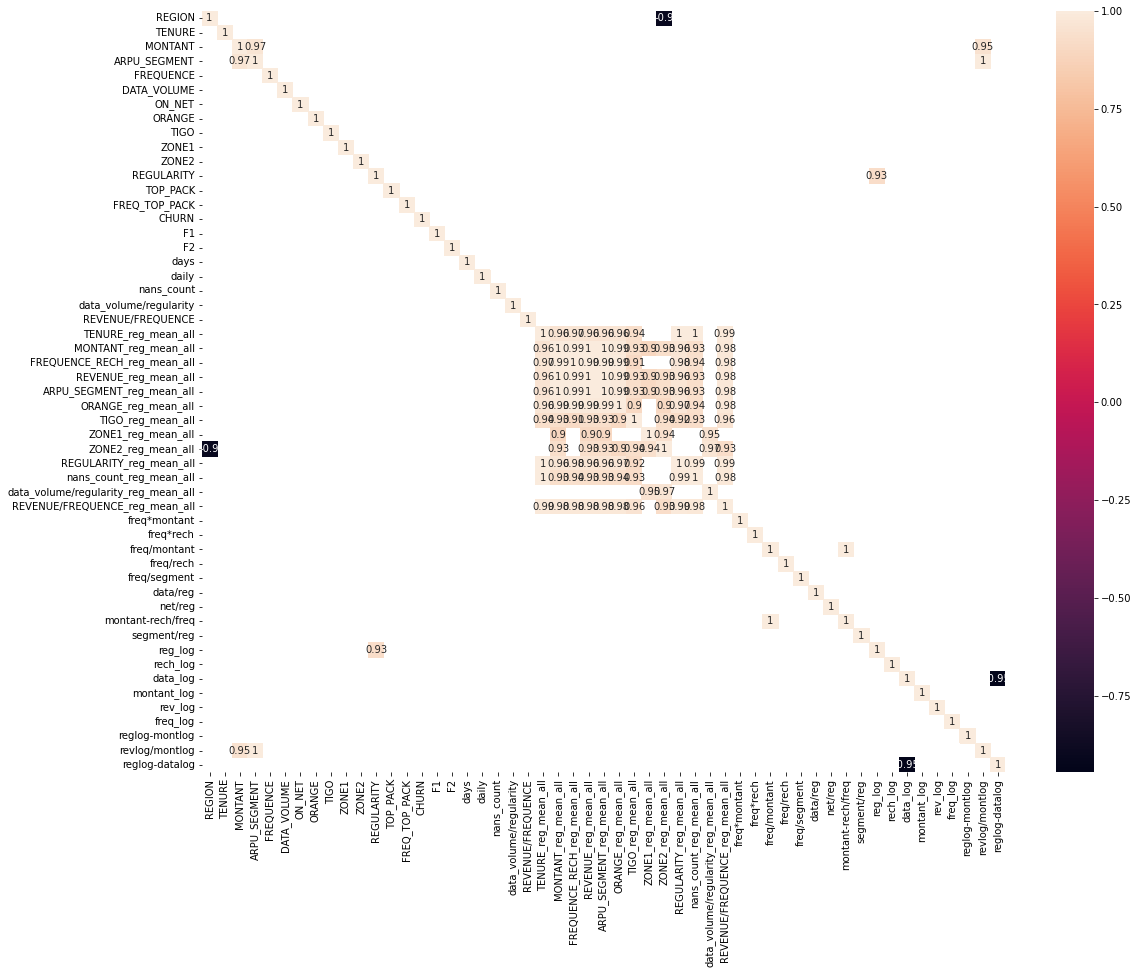

In [ ]:
plt.figure(figsize=(18,14))
sns.heatmap(df_final.corr()[abs(df_final.corr())>0.9],annot=True)
df_final = df.drop(columns=['REVENUE','FREQUENCE_RECH','FREQ_TOP_PACK_reg_mean_all','DATA_VOLUME_reg_mean_all','ON_NET_reg_mean_all','FREQUENCE_reg_mean_all'])

TEST = TEST.drop(columns=['REVENUE','FREQUENCE_RECH','FREQ_TOP_PACK_reg_mean_all','DATA_VOLUME_reg_mean_all','ON_NET_reg_mean_all','FREQUENCE_reg_mean_all'])

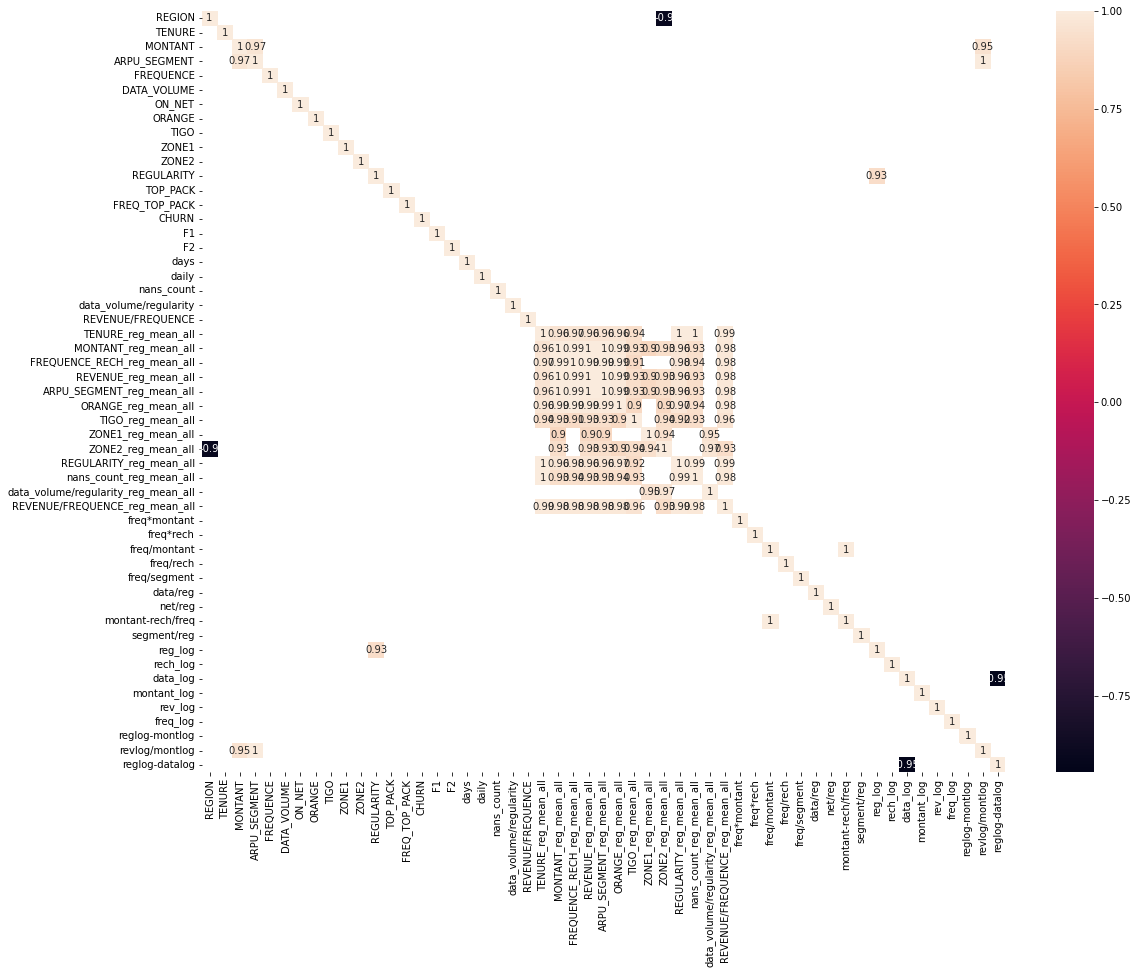

In [ ]:
plt.figure(figsize=(18,14))
sns.heatmap(df_final.corr()[abs(df_final.corr())>0.9],annot=True)

In [ ]:
df_final

,user_id,REGION,TENURE,MONTANT,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,F1,F2,days,daily,nans_count,data_volume/regularity,REVENUE/FREQUENCE,TENURE_reg_mean_all,MONTANT_reg_mean_all,FREQUENCE_RECH_reg_mean_all,REVENUE_reg_mean_all,ARPU_SEGMENT_reg_mean_all,FREQUENCE_reg_mean_all,DATA_VOLUME_reg_mean_all,ON_NET_reg_mean_all,ORANGE_reg_mean_all,TIGO_reg_mean_all,ZONE1_reg_mean_all,ZONE2_reg_mean_all,REGULARITY_reg_mean_all,FREQ_TOP_PACK_reg_mean_all,nans_count_reg_mean_all,data_volume/regularity_reg_mean_all,REVENUE/FREQUENCE_reg_mean_all,freq*montant,freq*rech,freq/montant,freq/rech,freq/segment,data/reg,net/reg,montant-rech/freq,segment/reg,reg_log,rech_log,data_log,montant_log,rev_log,freq_log,reglog-montlog,revlog/montlog,reglog-datalog
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,2,24,4250.000000,1417.000000,17.000000,4.000000,388.00000,46.000000,1.000000,1.000000,2.000000,54,67,8.000000,0,200,0,0,1,3,0.072727,236.166667,23.846814,4546.160201,9.748546,4548.944265,1516.324729,11.989947,1144.018085,369.736082,86.440724,20.021786,3.680697,3.785479,37.898073,7.793467,7.199085,25.877342,320.505833,72250.000000,255.000000,250.000000,1.133333,0.011997,0.074074,7.185185,249.117647,26.240741,4.007333,2.772589,1.609438,8.354910,8.355145,2.890372,-4.347576,508.802637,2.397895
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,14,21,3542.383237,1146.296165,9.221789,2941.364300,150.54949,54.674819,15.821471,8.258238,8.083267,4,83,6.442927,1,0,0,0,1,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32667.112042,70.772355,384.131875,1.201619,0.008045,735.341075,37.637372,383.299664,286.574041,1.609438,2.160384,7.986969,8.172837,8.143188,2.324522,-6.563399,420.767931,-6.377531
2,00001654a9d9f96303d9969d0a4a851714a4bb57,14,24,3600.000000,340.000000,2.000000,2941.364300,90.00000,46.000000,7.000000,8.258238,8.083267,17,68,1.000000,0,1000,0,10,1,6,0.000000,340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7200.000000,4.000000,1800.000000,1.000000,0.005882,173.021429,5.294118,1799.000000,20.000000,2.890372,1.098612,7.986969,8.188967,6.928538,1.098612,-5.298595,124.557837,-5.096597
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,0,24,13500.000000,4501.000000,18.000000,43804.000000,41.00000,102.000000,2.000000,12.481805,9.555484,62,20,11.000000,0,1000,0,7,1,4,695.301587,710.631579,23.791882,7301.405194,14.405930,7346.988920,2449.000013,17.611069,5472.724140,252.553421,121.900325,26.589621,12.481805,9.555484,37.794923,11.371454,6.619361,109.931009,393.334294,243000.000000,270.000000,750.000000,1.200000,0.003999,706.516129,0.661290,749.166667,72.596774,4.143135,2.772589,10.687503,9.510519,9.510667,2.944439,-5.367384,1419.691181,-6.544369
4,000028d9e13a595abe061f9b58f3d76ab907850f,0,24,1000.000000,328.000000,1.000000,5472.724140,39.00000,24.000000,26.589621,12.481805,9.555484,11,51,2.000000,0,250,0,0,1,7,0.000000,492.500000,23.791882,7301.405194,14.405930,7346.988920,2449.000013,17.611069,5472.724140,252.553421,121.900325,26.589621,12.481805,9.555484,37.794923,11.371454,6.619361,109.931009,393.334294,1000.000000,1.000000,1000.000000,1.000000,0.003049,497.520376,3.545455,999.000000,29.818182,2.484907,0.693147,8.607714,6.908755,6.893656,0.693147,-4.423848,142.572726,-6.122808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154043,ffffe85215ddc71a84f95af0afb0deeea90e6967,14,24,3542.383237,1146.296165,9.221789,2941.364300,150.54949,54.674819,15.821471,8.258238,8.083267,6,83,6.442927,0,0,0,0,1,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

# Split data on train, val, test. Machine Learning

In [ ]:
!pip install optuna
import optuna
import lightgbm as lgb



In [ ]:
train, validate, test = np.split(df_final.sample(frac=1, random_state=42),
                                 [int(.8 * len(df_final)), int(.9 * len(df_final))])

In [ ]:
y_train = train.CHURN
X_train = train.drop(columns=['CHURN','user_id'])
X_test, y_test = test.drop(columns=['CHURN','user_id']), test.CHURN
X_val, y_val = validate.drop(columns=['CHURN','user_id']), validate.CHURN

In [ ]:
def find_hyperparams(trial):
  lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                            lambda_l2= trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                            num_leaves= trial.suggest_int('num_leaves', 2, 128),
                            feature_fraction= trial.suggest_float('feature_fraction', 0.5, 1.0),
                            bagging_fraction= trial.suggest_float('bagging_fraction', 0.5, 1.0),
                            bagging_freq = trial.suggest_int('bagging_freq', 2, 32),
                            min_child_samples= trial.suggest_int('min_child_samples', 4, 150), n_estimators = trial.suggest_int('n_estimators', 100, 350),first_metric_only = True)
  lgb_model.fit(X_train,y_train)
  preds = lgb_model.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, preds)
  return auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(find_hyperparams, n_trials=100)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

[I 2021-11-07 09:13:09,302] A new study created in memory with name: no-name-d25750a0-9dc1-4c26-881c-cd05020f2816
[I 2021-11-07 09:14:22,812] Trial 0 finished with value: 0.9310994313484725 and parameters: {'lambda_l1': 0.08218117643251346, 'lambda_l2': 2.4386847459528502e-08, 'num_leaves': 96, 'feature_fraction': 0.5231616998826865, 'bagging_fraction': 0.7962856498849332, 'bagging_freq': 30, 'min_child_samples': 67, 'n_estimators': 186}. Best is trial 0 with value: 0.9310994313484725.
[I 2021-11-07 09:16:07,774] Trial 1 finished with value: 0.9292785093631972 and parameters: {'lambda_l1': 1.0275755784483196e-06, 'lambda_l2': 0.0001532532170280649, 'num_leaves': 117, 'feature_fraction': 0.549656423823445, 'bagging_fraction': 0.8683316517599554, 'bagging_freq': 28, 'min_child_samples': 15, 'n_estimators': 248}. Best is trial 0 with value: 0.9310994313484725.
[I 2021-11-07 09:16:43,039] Trial 2 finished with value: 0.9306190128035935 and parameters: {'lambda_l1': 0.0005398458799126581, '

KeyboardInterrupt: ignored

In [ ]:
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 9.995422529255574,
                            lambda_l2= 8.269905966999003,
                            num_leaves= 44,
                            feature_fraction= 0.991240835191539,
                            bagging_fraction= 0.9533162437537327,
                            bagging_freq = 19,
                            min_child_samples= 63, n_estimators = 246,first_metric_only = True)
target = y_train
lgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds = 30,verbose=True)

[1]	valid_0's auc: 0.929072
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.929529
[3]	valid_0's auc: 0.929581
[4]	valid_0's auc: 0.929786
[5]	valid_0's auc: 0.929816
[6]	valid_0's auc: 0.929951
[7]	valid_0's auc: 0.930077
[8]	valid_0's auc: 0.930119
[9]	valid_0's auc: 0.930144
[10]	valid_0's auc: 0.930196
[11]	valid_0's auc: 0.930225
[12]	valid_0's auc: 0.930258
[13]	valid_0's auc: 0.930279
[14]	valid_0's auc: 0.930403
[15]	valid_0's auc: 0.930426
[16]	valid_0's auc: 0.930447
[17]	valid_0's auc: 0.930464
[18]	valid_0's auc: 0.930483
[19]	valid_0's auc: 0.930484
[20]	valid_0's auc: 0.930525
[21]	valid_0's auc: 0.930541
[22]	valid_0's auc: 0.930556
[23]	valid_0's auc: 0.930574
[24]	valid_0's auc: 0.930596
[25]	valid_0's auc: 0.930613
[26]	valid_0's auc: 0.930634
[27]	valid_0's auc: 0.930642
[28]	valid_0's auc: 0.93067
[29]	valid_0's auc: 0.930693
[30]	valid_0's auc: 0.930724
[31]	valid_0's auc: 0.930751
[32]	valid_0's auc: 0.930775
[33]	valid_0's auc: 

LGBMClassifier(bagging_fraction=0.9533162437537327, bagging_freq=19,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.991240835191539, first_metric_only=True,
               importance_type='split', lambda_l1=9.995422529255574,
               lambda_l2=8.269905966999003, learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=63, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=246, n_jobs=-1, num_leaves=44,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
prediction=lgb_model.predict_proba(X_test,num_iteration = lgb_model.best_iteration_)[:,1]

In [ ]:
roc_auc_score(y_test,prediction)

ValueError: ignored

In [ ]:
test_user_id=TEST.user_id
X_test=TEST.drop(columns=['user_id'])

In [ ]:
submit_prediction = lgb_model.predict_proba(X_test,num_iteration = lgb_model.best_iteration_)[:,1]

In [ ]:
submission = pd.concat([test_user_id,pd.DataFrame(submit_prediction,columns=['CHURN'])],axis=1)

In [ ]:
submission

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.002021
1,000055d41c8a62052dd426592e8a4a3342bf565d,0.802423
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0.064214
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0.537023
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0.484332
...,...,...
380122,fffe7e03c7eede2ad0a728ee516c4d342dd16107,0.066591
380123,fffec230e6a1aa51ab37d0051ece42de611e71c6,0.639962
380124,ffff0dcc1ab9812bf205b6d76e9d084053cd96f5,0.155212
380125,ffff91ea6a09a0c8ea42bc6ae33df4b5e06283dc,0.249122


In [ ]:
submission.to_csv('/content/submission.csv',index=False)